# Stochastic Differential Equations, Quantum Phase Space, and Julia 

$$
\def\julia{\texttt{julia}}
\def\dashint{{\int\!\!\!\!\!\!-\,}}
\def\infdashint{\dashint_{\!\!\!-\infty}^{\,\infty}}
\def\D{\,{\rm d}}
\def\E{{\rm e}}
\def\dx{\D x}
\def\dt{\D t}
\def\dz{\D z}
\def\C{{\mathbb C}}
\def\R{{\mathbb R}}
\def\CC{{\cal C}}
\def\HH{{\cal H}}
\def\I{{\rm i}}
\def\qqqquad{\qquad\qquad}
\def\qqfor{\qquad\hbox{for}\qquad}
\def\qqwhere{\qquad\hbox{where}\qquad}
\def\Res_#1{\underset{#1}{\rm Res}}\,
\def\sech{{\rm sech}\,}
\def\vc#1{{\mathbf #1}}
$$

Dr. Ashton Bradley
<br>
ashton.bradley@otago.ac.nz
<br>
http://amoqt.otago.ac.nz

## Workshop 2 (1 hour) 
- Numerical Wiener process
- Intro to `DifferentialEquations.jl`

References
- *An algorithmic introduction to numerical simulation of stochastic differential equations*, D. J. Higham, [SIAM Review, __43__, 525-546 (2001)](https://epubs.siam.org/doi/abs/10.1137/S0036144500378302)

# Wiener process
The _Wiener process_ $W(t)$, depending continuously on $t\in[0,T]$, has the following defining properties:
1. $W(0)=0$ (with probability 1).
2. For $0\leq s<t\leq T$ the random variable given by the increment $W(t)-W(0)$ is normally distributed with mean zero and variance $t-s$. 
3. For $0\leq s<t<u<v\leq T$ the increments $W(t)-W(s)$ and $W(v)-W(u)$ are independent. 

Property 2 is the statement that the Wiener process can be described by a normal random variable:

>$W(t)-W(s)\sim \sqrt{t-s}N(0,1)$, where $N(0,1)$ is a scaled Gaussian random variable with mean zero and unit variance. In $\julia$ this is `randn()`.

Property 3 is the statement that the Wiener process is a _Markov process_ (memoryless).

The Wiener process is often referred to as simply ___Brownian motion___ since it is the fundamental process governing Brownian motion as derived by Einstein, with diffusion coefficient $D\equiv 1$.

# Computational Wiener process
On a computer we always deal with discretizations. The discretized Brownian motion is equivalent to a set of samples from `randn()`, with scaling by $\sqrt{\Delta t}$. 

In [6]:
using Statistics, Plots, LaTeXStrings, Revise
gr(grid=false,legend=false,size=(400,200),titlefontsize=10)

Plots.GRBackend()

In [7]:
randn() # part of base julia

-1.2823779027693414

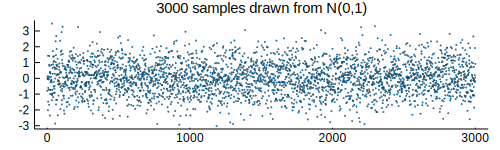

In [8]:
N = 3000
x = randn(N)
n = 1:N 
plot(n,x,seriestype=:scatter,ms=1,size=(500,150))
title!("$N samples drawn from N(0,1)")

In [9]:
mean(x),var(x) # from the Statistics package

(0.032630586939194094, 1.0291156804040478)

In [11]:
T = 1; N = 500; dt = T/N
t = LinRange(0,T,N+1)
W = zeros(N)
ŒîW = sqrt(dt)*randn(N); #all independent

In [12]:
mean(ŒîW), var(ŒîW), dt, length(t)

(0.0002865502988770673, 0.002052912724313275, 0.002, 501)

We single out the initial condition as a special point with index $j=0$, and use the discretized definition

$ W_j\equiv W_{j-1} + ŒîW_j$

with $j=1,2,..., N$. This choice is consistent with julia's "1-indexing" of arrays.

In [13]:
W[1] = ŒîW[1] 
for j in 2:N 
    W[j] = W[j-1] + ŒîW[j]
end
W = [0.0; W]; # careful here! - in jupyter we can do out of order execution

In [14]:
mean(W), length(W)

(-0.1291695403659743, 501)

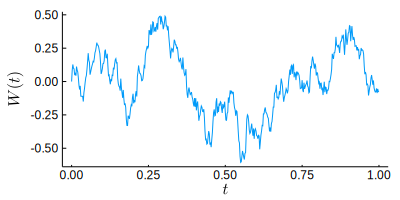

In [21]:
dt = T/N
plot(t,W)
xlabel!(L"t");ylabel!(L"W(t)")

Let's deal with the sampling and initial condition inside a single function that samples one path, for `N` steps. 

We can also easily add a short documentation string to explain the function. This gives an example of documentation conventions and notation.

In [16]:
"""
`t,ŒîW,W = wienerpath(N,T)`

Sample a path of the Wiener process over time interval `[0,T]` for `N` increments `ŒîW` and initial condition `W(t=0)=W[1]=0.0`. 

Outputs:

- `t` time vector, of length `N+1`
- `ŒîW` vector of increments, of length `N`
- `W` vector of `W[j]` at time points `t=t_j` with `j=1,2,...,N` corresponding to increments. The initial value is included, giving a vector of length `N+1`.
"""
function wienerpath(N,T)
    dt = T/N
    t = 0:dt:T |> collect
    dW = sqrt(dt)*randn(N)
    W = cumsum(dW)
    W = [0.0;W]
    return t,dW,W
end

wienerpath

The function is now part of our current julia session, and the documentation is also part of julia:

In [17]:
?wienerpath

search: wienerpath



`t,ŒîW,W = wienerpath(N,T)`

Sample a path of the Wiener process over time interval `[0,T]` for `N` increments `ŒîW` and initial condition `W(t=0)=W[1]=0.0`. 

Outputs:

  * `t` time vector, of length `N+1`
  * `ŒîW` vector of increments, of length `N`
  * `W` vector of `W[j]` at time points `t=t_j` with `j=1,2,...,N` corresponding to increments. The initial value is included, giving a vector of length `N+1`.


We can also save the same code to a file, say `wienerpath.jl`, and load it by executing the command
`include("wienerpath.jl")`

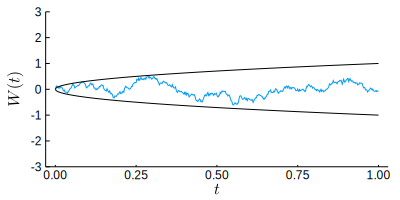

In [20]:
N = 500
t,ŒîW,W = wienerpath(N,1)
p1=plot(t,W)
plot!(t,sqrt.(t),linewidth=1,c=:black)
plot!(t,-sqrt.(t),linewidth=1,c=:black)
ylims!(-3,3);xlabel!(L"t");ylabel!(L"W(t)")

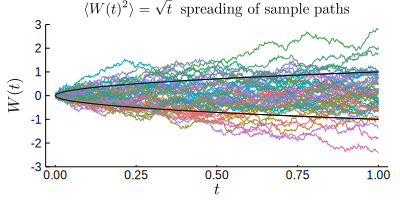

In [22]:
Np = 50
for j = 1:Np
    t,ŒîW,W = wienerpath(N,1)
    plot!(p1,t,W,legend=false)
end
plot!(t,sqrt.(t),linewidth=1,c=:black)
plot!(t,-sqrt.(t),linewidth=1,c=:black)
title!(L"\langle W(t)^2\rangle=\sqrt{t}\;\; \textrm{spreading of sample paths}")

Let's make a simple animated `.gif` of wienerpaths:

‚îå Info: Saved animation to 
‚îÇ   fn = /Users/abradley/Dropbox/Julia/ANZSUP2019/ANZSUP19_Stochastic/media/wpaths.gif
‚îî @ Plots /Users/abradley/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/Users/abradley/Dropbox/Julia/ANZSUP2019/ANZSUP19_Stochastic/media/wpaths.gif")
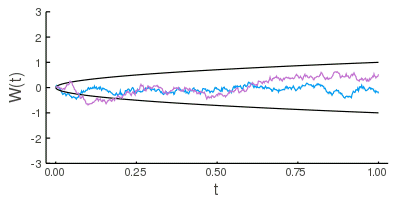

In [25]:
N = 500
t,ŒîW,W = wienerpath(N,1)
p1 = plot(t,W)
plot!(t,sqrt.(t),linewidth=1,c=:black)
plot!(t,-sqrt.(t),linewidth=1,c=:black)
ylims!(-3,3);xlabel!("t");ylabel!("W(t)")

anim = @animate for i=1:150
t,ŒîW,W = wienerpath(N,1)
plot!(p1,t,W)
end

gif(anim,"media/wpaths.gif", fps = 12)

# FPE solution for Brownian motion
The diffusion equation

$$\frac{\partial p(x,t|0,0)}{\partial t}=\frac{1}{2}\frac{\partial^2p(x,t|0,0)}{\partial x^2}$$

with ideally localized initial condition $p(x,t=0|0,0) = n\delta(x)$ has solution

$$p(x,t|0,0)=\frac{n}{\sqrt{2\pi t}}e^{-x^2/2t}$$

In [26]:
p(x,t) = exp(-x^2/(2t))/sqrt(2œÄ*t) # scalar function definition

p (generic function with 1 method)

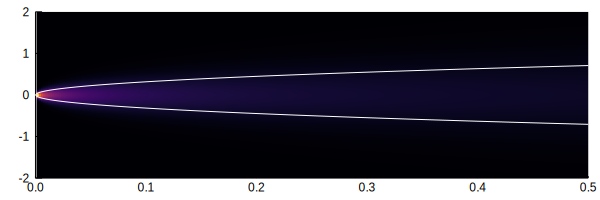

In [30]:
y = LinRange(-2,2,500)
heatmap(t,y,p.(y,t'),size=(600,200),transpose=false) # broadcast
plot!(t,sqrt.(t),lw=1,c=:white)
plot!(t,-sqrt.(t),lw=1,c=:white)
xlims!(0,.5);ylims!(-2,2)

‚îå Warning: rainbow is found in more than one library: misc, colorcet. Choosing misc
‚îî @ PlotUtils /Users/abradley/.julia/packages/PlotUtils/10ojB/src/color_gradients.jl:40


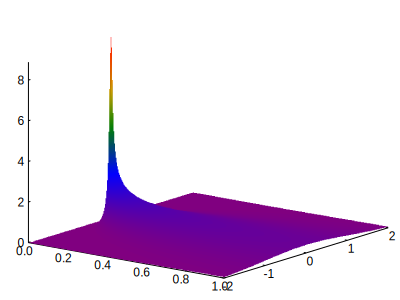

In [31]:
# another plot example
p1=surface(t,y,p.(y,t'),c = :rainbow,size=(400,300))
plot!(p1, camera=(40, 40))

# Ensemble average
Let's compute a simple stochastic average over our Wiener increments. 

We can graph the sample average for a set of sample paths of the Wiener process. 

- We show the average, and a few sample paths, of the function $f(t)=e^{t+W(t)/2}$. 
- The known analytic result for the mean is $\langle f(t)\rangle =e^{9t/8}$.

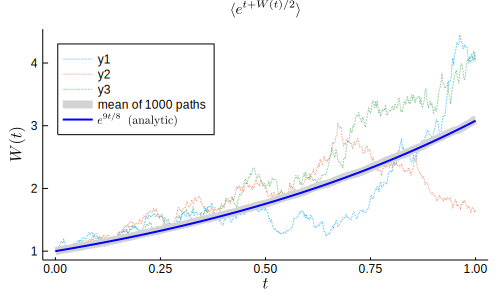

In [32]:
T = 1; N = 500; Œît = T/N 
t = LinRange(0,T,N+1)
Np = 1000
ŒîW = sqrt(Œît)*randn(N,Np)
W = cumsum(ŒîW,dims=1)
W = [zeros(1,Np); W]
U = @. exp(t + 0.5*W) # broadcast (!!)
≈™ = mean(U,dims=2) # path average at each time
plot(t,U[:,1:3],s=:dot,size=(500,300)) # show a few paths
plot!(t,≈™,w=8,c=:lightgrey,label="mean of $Np paths",legend=:topleft)
plot!(t,exp.(9t/8),w=2,c=:blue,label=L"e^{9t/8}\;\;\textrm{(analytic)}")
xlabel!(L"t");ylabel!(L"W(t)")
title!(L"\langle e^{t+W(t)/2}\rangle")

## Theorem
If $u$ is a Gaussian variable with mean $\langle u\rangle =0$ and variance $\langle u^2\rangle=\sigma^2$, then 

$$ \langle e^{\alpha u}\rangle = e^{\alpha^2\sigma^2/2}$$

__Exercise:__ use this to prove the analytic result for $\langle f(t)\rangle$ given above.

# Differential Equations
Chris Rackauckas (recent Math PhD at UC Irvine, now Postdoc at MIT) has written an julia maserpiece for solving differential equations in $\julia$.
- An expert on SDE's, and expert programmer.
- Wanted to compare results for different SDE methods and problems
- Realized there was no decent package for numerical solving
- `DifferentialEquations.jl` is now world-leading in every aspect of numerical solving
- State of the art adaptive stochastic integration methods, only published 2018 (now being copied by other libraries).
- See also his blog [Stochastic Lifestyle](http://www.stochasticlifestyle.com/) for some really nice resources for learning more about $\julia$.
- See a comparison [here](http://www.stochasticlifestyle.com/comparison-differential-equation-solver-suites-matlab-r-julia-python-c-fortran/)

To compare with library of similar convenience, for a small problem (comparable to predator-prey considered below) how does it compare with Matlab's ODE45?

<img src="media/comparison.png" width="600">

Yes, that is two orders of magnitude!

In [33]:
using DifferentialEquations, Statistics, Plots, LaTeXStrings, Revise
gr(grid=false,legend=false,size=(400,200),titlefontsize=12)

‚îå Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
‚îî @ Base loading.jl:1260


Plots.GRBackend()

# A cute example: predator-prey model

## Equations of motion
The **Lotka-Volterra equations** for this system take the form:
<div class="alert alert-block alert-warning">
<font color=blue>
\begin{align}
\frac{dr}{dt}&=\lambda r - \gamma wr\\
\frac{dw}{dt}&=-\beta w + \sigma rw 
\end{align}
</font>
</div>
The solutions of this two-variable system of coupled nonlinear equations tells us everything about our simple model for population dynamics.  

In [ ]:
#\:rabbit2: = üêá #remember to tab-complete 
#\:wolf: = üê∫
#\lambda<tab> = Œª #etc

In [36]:
# system parameters
Œª = .7  # üêá growth
Œ≥ = 0.4  # üêá loss
œÉ = 0.3  # üê∫ growth
Œ≤ = 1.2  # üê∫ loss

# define the equations of motion (standard first order form)
# in-place vector syntax
function predatorprey!(du,u,p,t)
    du[1] =  p[1]*u[1] - p[2]*u[2]*u[1]
    du[2] = -p[3]*u[2] + p[4]*u[1]*u[2]
end

predatorprey! (generic function with 1 method)

the function signature (first line) shows the required form 
if you are writing your own function to pass to DifferentialEquations. In this "in-place form", you have to first declare the place the differentials are written to (`du`), then declare the unknown fields (`u`), then a set of parameters (`p`), and finally time `t`. Note that in our equatnions of motion (EOM), we don't make use of `t`, and in general it is not a requirement that `p` is used either, just that the function signature has this general form. For the "out-of-place" form, this would become `predatorprey(u,p,t)`, and we would need to replace `return nothing` with `return x`, where `x` is the result of evaluating the right hand side of our EOM.

Define EOM using a macro from [ParameterizedFunctions.jl](https://github.com/JuliaDiffEq/ParameterizedFunctions.jl)

In [37]:
pprey = @ode_def_all LotkaVolterra begin
  düêá = Œª*üêá - Œ≥*üê∫*üêá
  düê∫ = -Œ≤*üê∫ + œÉ*üêá*üê∫
end Œª Œ≥ Œ≤ œÉ

(::LotkaVolterra{var"###ParameterizedDiffEqFunction#333",var"###ParameterizedTGradFunction#334",var"###ParameterizedJacobianFunction#335",var"###ParameterizedWFactFunction#336",var"###ParameterizedW_tFactFunction#337",ModelingToolkit.ODESystem}) (generic function with 1 method)

The macro writes a bunch of methods with the right syntax to pass to `DifferentialEquations` using your declared set of unknowns. Note that the unknowns are declared implicitly by stating the equations. Again, the syntax is that you should write `dx = ...` for each equation of motion, dropping the redundant `dt` that would appear on the right hand side if this was a rigorous mathematical statement of your equations of motion. 
    

# Fixed point
Let us first verify that if we start at a known fixed point, 
it really _is_ a stationary solution 

In [38]:
rÃÑ = Œ≤/œÉ
wÃÑ = Œª/Œ≥
u0 = [rÃÑ ; wÃÑ]
ti = 0.0
tf = .2
Nt = 100
tspan = (ti,tf)
t = LinRange(ti,tf,Nt) 
params = [Œª; Œ≥; Œ≤; œÉ]

#define the problem type
prob = ODEProblem(pprey,u0,tspan,params)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 0.2)
u0: [4.0, 1.7499999999999998]

First call triggers the JIT

In [39]:
# solve the problem, saving at specified time points
@time sol = solve(prob,saveat=t);

 10.833241 seconds (33.65 M allocations: 1.708 GiB, 5.61% gc time)


The solution time for compiled code:

In [40]:
# solve the problem, saving at specified time points
@time sol = solve(prob,saveat=t);

  0.000214 seconds (280 allocations: 38.445 KiB)


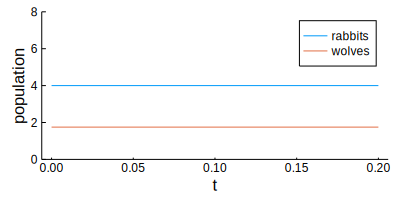

In [41]:
üêá = sol[1,:]; üê∫ = sol[2,:]
plot(t,üêá,label="rabbits",legend=:topright);plot!(t,üê∫,label="wolves")
ylims!(0,8);xlabel!("t");ylabel!("population")

Now let us ask what happens if the rabbits and wolves start near, but not exactly at, a fixed point?

In [42]:
# parameters
Œª = .7  # üêá growth
Œ≥ = 0.4  # üêá loss
œÉ = 0.3  # üê∫ growth
Œ≤ = 1.2  # üê∫ loss
params = [Œª; Œ≥; Œ≤; œÉ]
rÃÑ = Œ≤/œÉ; wÃÑ = Œª/Œ≥

œµ = .1
u0 = [Œ≤/œÉ + œµ ; Œª/Œ≥ - œµ] # one slightly larger, one slightly smaller
ti = 0.0
tf = 50.0
Nt = 200
tspan = (ti,tf)
t = LinRange(ti,tf,Nt) 

prob = ODEProblem(pprey,u0,tspan,params)
@time sol = solve(prob,saveat=t);

  0.000273 seconds (382 allocations: 64.961 KiB)


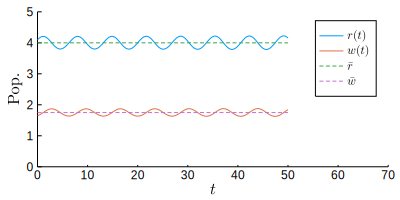

In [47]:
üêá = sol[1,:]; üê∫ = sol[2,:]
plot(t,üêá,label=L"r(t)",legend=:topright);plot!(t,üê∫,label=L"w(t)")
plot!(t,rÃÑ*one.(t),label=L"\bar r",s=:d)
plot!(t,wÃÑ*one.(t),label=L"\bar w",s=:d)
ylims!(0,5);xlabel!(L"t");ylabel!(L"\textrm{Pop.}")
xlims!(0,70)

Great. Let's say we want to study behavior as a function of how far the populations start from the steady state. 

We wrap the heavy-lifting code from above inside a fuction (let's avoid global scope and simplify):

In [48]:
function pprey_shift(œµ)
# parameters
Œª = .7  # üêá growth
Œ≥ = 0.4  # üêá loss
œÉ = 0.3  # üê∫ growth
Œ≤ = 1.2  # üê∫ loss
params = [Œª; Œ≥; Œ≤; œÉ]

u0 = [Œ≤/œÉ + œµ ; Œª/Œ≥ - œµ] # one slightly larger, one slightly smaller
ti = 0.0
tf = 50.0
Nt = 200
tspan = (ti,tf)
t = LinRange(tspan...,Nt) 

prob = ODEProblem(pprey,u0,tspan,params)
sol = solve(prob,saveat=t);
üêá = sol[1,:]; üê∫ = sol[2,:]
    return üêá, üê∫
end

pprey_shift (generic function with 1 method)

In [49]:
using Interact

‚îå Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
‚îî @ Base loading.jl:1260


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-13732084086153825770\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4937690175009838911\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-13732084086153825770\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-11641017168949061951\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-283670097079194\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-11641017168949061951\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [59]:
œµmax = 1.2
Neps = 50
œµvec = LinRange(0.0,œµmax,Neps)

p1=plot(size=(600,200))
@manipulate for œµ in œµvec 
    üêá, üê∫ = pprey_shift(œµ)
    plot(t,üêá,label=L"r(t)",legend=:topright);plot!(t,üê∫,label=L"w(t)",foreground_color_legend = nothing)
    plot!(t,rÃÑ*one.(t),label=L"\bar r",s=:d)
    plot!(t,wÃÑ*one.(t),label=L"\bar w",s=:d)
    ylims!(0,5);xlabel!(L"t");ylabel!(L"\textrm{Pop.}")
    xlims!(0,70);ylims!(0,8)
    title!("Predator-prey dynamics")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["œµ"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 50,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
25, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/abradley/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/abradley/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/abradley/.julia/packages/InteractBase/NMcus/src/../assets/all.js"), Asset("css", nothing, "/Users/abradley/.julia/packages/InteractBase/NMcus/src/../assets/style.css"), Asset("css", nothing, "/Users/abradley/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000013a31f850, Task (runnable) @0x000000013a31f850), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.0244898\",\"0.0489796\",\"0.0734694\",\"0.0979592\",\"0.122449\",\"0.146939\",\"0.171429\",\"0.195918\",\"0.220408\",\"0.244898\",\"0.269388\",\"0.293878\",\"0.318367\",\"0.342857\",\"0.367347\",\"0.391837\",\"0.416327\",\

Fast enough to easily run and plot in real time while scanning parameter space.

We can easily use the same code to make an animated .gif to scan over the results:

‚îå Info: Saved animation to 
‚îÇ   fn = /Users/abradley/Dropbox/Julia/ANZSUP2019/ANZSUP19_Stochastic/media/ppdynamics.gif
‚îî @ Plots /Users/abradley/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/Users/abradley/Dropbox/Julia/ANZSUP2019/ANZSUP19_Stochastic/media/ppdynamics.gif")
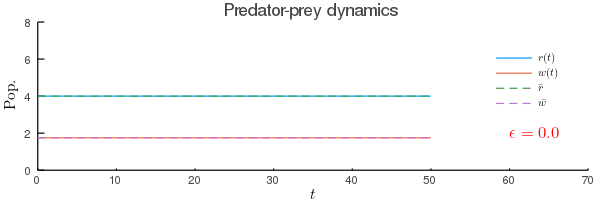

In [81]:
p1=plot()
anim=@animate for œµ in œµvec 
    üêá, üê∫ = pprey_shift(œµ)
    plot(t,üêá,label=L"r(t)",legend=:topright,size=(600,200));plot!(t,üê∫,label=L"w(t)",foreground_color_legend = nothing)
    plot!(t,rÃÑ*one.(t),label=L"\bar r",s=:d)
    plot!(t,wÃÑ*one.(t),label=L"\bar w",s=:d)
    ylims!(0,5);xlabel!(L"t");ylabel!(L"\textrm{Pop.}")
    xlims!(0,70);ylims!(0,8)
    title!("Predator-prey dynamics")
    annotate!(60,2,text(latexstring("\\epsilon=$(round(œµ;digits=2))"), :red,:left, 12))
end
gif(anim,"./media/ppdynamics.gif",fps=15)

# Workshop 3
- Quantum phase space with SDE's and julia